# Lesson 6

## 00:00:15 - Blog posts

* [Optimization for Deep Learning Highlights in 2017](http://ruder.io/deep-learning-optimization-2017/) by Sebastian Ruder
  * Covers learning rate tuning techniques.
  * Optimization stuff covered in Fast.ai

## 00:02:18 - Collaborative filter review

* Model recap: summed to user and movie embeddings, adde the relevant biases and pushed through a sigmoid to force it between 1 and 5.

### 00:03:29 - Interpretting model results

* Retrain model from last lesson:

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.fastai.learner import *
from fastai.fastai.column_data import *

In [2]:
PATH = 'data/ml-latest-small/'

In [3]:
!ls -l {PATH}

total 7936
-rw-r--r--  1 lex  staff     8364 18 Oct  2016 README.txt
-rw-r--r--  1 lex  staff   183372 18 Oct  2016 links.csv
drwxr-xr-x  7 lex  staff      238 18 Oct  2016 ml-latest-small
-rw-r--r--  1 lex  staff   918269 18 Oct  2016 ml-latest-small.zip
drwxr-xr-x  2 lex  staff       68 23 Apr 17:31 models
-rw-r--r--  1 lex  staff   458390 18 Oct  2016 movies.csv
-rw-r--r--  1 lex  staff  2438266 18 Oct  2016 ratings.csv
-rw-r--r--  1 lex  staff    41902 18 Oct  2016 tags.csv
drwxr-xr-x  2 lex  staff       68 23 Apr 17:31 tmp


In [10]:
ratings = pd.read_csv(f'{PATH}ratings.csv')
movies = pd.read_csv(f'{PATH}movies.csv')

In [14]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [11]:
val_idxs = get_cv_idxs(len(ratings))
wd = 2e-4
n_factors = 50

In [12]:
cf = CollabFilterDataset.from_csv(PATH, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [16]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.787726   0.808975  
    1      0.741712   0.778309                                 
    2      0.593008   0.764146                                 



[0.7641464]

In [17]:
math.sqrt(0.764146)

0.8741544485958989

In [21]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:3000]
top_movie_idx = np.array([cf.item2idx[o] for o in topMovies])

* Can grab model attribute from `learn` as follows:

In [18]:
m = learn.model

In [19]:
m

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

* Nice thing about PyTorch layers and models is they can be called as if they were a function.
  * To get a prediction from `m` you could call `m(...)`.

In [22]:
movie_bias = to_np(m.ib(V(top_movie_idx)))

In [23]:
movie_ratings = [(b[0], movie_names[i]) for i, b in zip(top_movies, movie_bias)]

* Note: new version of PyTorch has done away with Variables (`V`): everything is done with tensors.
* Fetching the top 3000 movie biases, returns you the following:

In [24]:
movie_bias

array([[ 0.81051],
       [ 0.9317 ],
       [ 1.28804],
       ...,
       [ 0.35272],
       [-0.07444],
       [ 0.23843]], dtype=float32)

* Jeremy's approach to PyTorch vs Numpy: try to use Numpy for everything, because it tends to be easier to work with. Use PyTorch when you need the GPU.

### 00:13:11 - Audience questions

* Q1: If you wanted to build a model with the GPU, how would you bring it to production (if you wanted to do inference on a CPU)?
* A1: You can move a model onto the CPU with `m.cpu()`:

In [27]:
m.cpu()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

* You can also move your variable to the cpu with the same method.
* Note: if you machine doesn't have a GPU, then the model will default to being on the CPU.

* Q2: If you train the model on the GPU, then save the embeddings and weights, do we have to do anything special to load to CPU?
* A2: The `load_model` function in Fast.ai will do that for you.

### 00:15:40 - Zip function in Python

* Iterates through a number of lists at the same time:

In [30]:
[(a, b) for (a, b) in zip([1, 2, 3], [-1, -2, -3])]

[(1, -1), (2, -2), (3, -3)]

### 00:16:13 - Worst and best movies

* Take a look at the lowest rated movies:

In [26]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.9591357, 'Battlefield Earth (2000)'),
 (-0.7401198, 'Super Mario Bros. (1993)'),
 (-0.723327, 'Wild Wild West (1999)'),
 (-0.7153927, 'Anaconda (1997)'),
 (-0.7062837, 'Speed 2: Cruise Control (1997)'),
 (-0.6958769, 'Batman & Robin (1997)'),
 (-0.6637389, 'Inspector Gadget (1999)'),
 (-0.6420721, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.60726595, 'Congo (1995)'),
 (-0.6037548, "Joe's Apartment (1996)"),
 (-0.6008505, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.6002087, 'Police Academy 6: City Under Siege (1989)'),
 (-0.5987116, 'Flintstones, The (1994)'),
 (-0.593846, 'Jaws 3-D (1983)'),
 (-0.59237915, 'Message in a Bottle (1999)')]

* This is a much more authenticate way to find out the worst movies, because averages can be skewed to popular movies.
  * The model removes the fact that people have different way of rating movies and different people have different tastes.

* Look at the highest rated movies:

In [31]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.2880398, 'Shawshank Redemption, The (1994)'),
 (1.1235328, 'Godfather, The (1972)'),
 (1.0433998, 'Usual Suspects, The (1995)'),
 (1.0182344, "Schindler's List (1993)"),
 (0.9418984, 'Godfather: Part II, The (1974)'),
 (0.9316962, 'Pulp Fiction (1994)'),
 (0.90957385, 'Fargo (1996)'),
 (0.8903549, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.8833299, '12 Angry Men (1957)'),
 (0.8742964, 'To Kill a Mockingbird (1962)'),
 (0.86819565, 'Silence of the Lambs, The (1991)'),
 (0.85250616, 'Memento (2000)'),
 (0.83772075,
  'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)'),
 (0.81366545, 'Casablanca (1942)'),
 (0.81237787, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)")]

* Do the same thing for embeddings:

In [33]:
movie_emb = to_np(m.i(V(top_movie_idx)))
movie_emb.shape

(3000, 50)

### 00:19:09 - Dimensionality reduction with PCA

* Can "compress" from high dimensional spaces into lower dim spaces using PCA.
  * PCA: principle components analysis.
  * Linear technique.
  * Almost identical to [Singular-Value Decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition). 
  * Covered in [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra/blob/master/README.md)

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=3)

In [36]:
movie_pca = pca.fit(movie_emb.T).components_

In [37]:
movie_pca.shape

(3, 3000)

* PCA tends to reduce down to the the "main" axis within a set of latent factors.

### 00:21:12 - Component analysis

* Don't know ahead of time what PCA is: it's just the main axis in the space of latent factors.
* Can look at it to interpret.

* First component:

In [59]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, top_movies)]

In [60]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.080935515, 'Chinatown (1974)'),
 (-0.06930936, 'Apocalypse Now (1979)'),
 (-0.06785644, 'Fargo (1996)'),
 (-0.06697278, 'Pulp Fiction (1994)'),
 (-0.06695497, 'Godfather: Part II, The (1974)'),
 (-0.066652894, 'Taxi Driver (1976)'),
 (-0.06514279, 'Goodfellas (1990)'),
 (-0.064437844, 'Shining, The (1980)'),
 (-0.06320854, 'Godfather, The (1972)'),
 (-0.062057443, '2001: A Space Odyssey (1968)')]

In [61]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06526648, 'Waterworld (1995)'),
 (0.06304584, 'Armageddon (1998)'),
 (0.060279433, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.059048332, 'Home Alone 3 (1997)'),
 (0.057475068, 'Police Academy 3: Back in Training (1986)'),
 (0.056599334, 'Batman Forever (1995)'),
 (0.0562668, 'Lethal Weapon 4 (1998)'),
 (0.05254713, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.052326966, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.05208972, 'Evolution (2001)')]

* Appears to be serious vs easy watching or class vs blockbustter.

In [62]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, top_movies)]

In [63]:
sorted(movie_comp, key=lambda a: a[0])[:10]

[(-0.10190022, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.0947872, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.09291439, 'Dark Knight, The (2008)'),
 (-0.08668499, 'Forrest Gump (1994)'),
 (-0.08604461,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.08211905, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.08165834, 'Shrek (2001)'),
 (-0.08057916, 'Jurassic Park (1993)'),
 (-0.0805724, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.07866651, 'Aladdin (1992)')]

In [64]:
sorted(movie_comp, key=lambda a: a[0], reverse=True)[:10]

[(0.05422154, 'Coneheads (1993)'),
 (0.0527766, 'Catwoman (2004)'),
 (0.048542097, 'Leaving Las Vegas (1995)'),
 (0.046938952, 'Deer Hunter, The (1978)'),
 (0.04638239, "Hard Day's Night, A (1964)"),
 (0.045679945, '8 1/2 (8½) (1963)'),
 (0.044834152, 'Flintstones, The (1994)'),
 (0.042646885, "Pee-wee's Big Adventure (1985)"),
 (0.042472742, 'Next Karate Kid, The (1994)'),
 (0.042354237, 'Bowfinger (1999)')]

* Maybe "crowd favorite" vs "polarising"?

In [65]:
fac2 = movie_pca[2]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac2, top_movies)]

In [66]:
sorted(movie_comp, key=lambda a: a[0])[:10]

[(-0.061886344, 'Babe (1995)'),
 (-0.056167528, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.055531766, "Schindler's List (1993)"),
 (-0.054243114, 'Hugo (2011)'),
 (-0.05321637, 'Space Jam (1996)'),
 (-0.052668817, 'Sense and Sensibility (1995)'),
 (-0.052206617, 'Bend It Like Beckham (2002)'),
 (-0.05192298, 'Simpsons Movie, The (2007)'),
 (-0.05108752, 'Mission: Impossible II (2000)'),
 (-0.05041575, 'Pleasantville (1998)')]

In [67]:
sorted(movie_comp, key=lambda a: a[0], reverse=True)[:10]

[(0.0783781, 'Clockwork Orange, A (1971)'),
 (0.07714958, 'Eyes Wide Shut (1999)'),
 (0.073235996, 'American Pie (1999)'),
 (0.066598274, 'Fight Club (1999)'),
 (0.06598015, 'Secretary (2002)'),
 (0.06425408, 'Clue (1985)'),
 (0.064237244, 'Beetlejuice (1988)'),
 (0.06398785, 'True Lies (1994)'),
 (0.063914016, 'Game, The (1997)'),
 (0.061613325, "Ferris Bueller's Day Off (1986)")]

* can draw a scatterplot of the first 2 components:

In [57]:
indexes = np.random.choice(len(top_movies), 50, replace=False)

In [68]:
X = fac0[indexes]
Y = fac1[indexes]

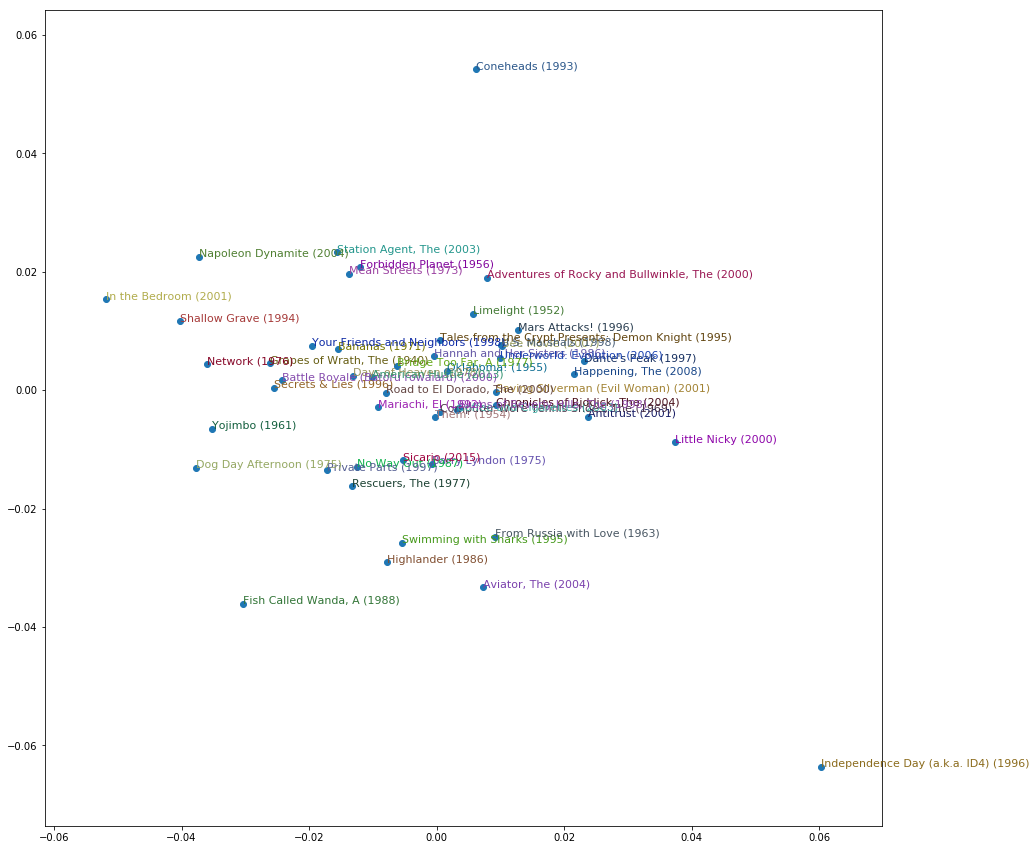

In [70]:
plt.figure(figsize=(15, 15 ))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[indexes], X, Y):
    plt.text(x, y, movie_names[i], color=np.random.rand(3) * 0.7, fontsize=11)
plt.show()

## 00:24:24- Evaluating embeddings of other models

* Q1: Can you interpet other types of embeddings (like the Rossman ones)?
* A1: Yes (starts next section).

* [Entity Embeddings of Categorical Variables](https://arxiv.org/pdf/1604.06737.pdf) paper

<img src="https://i.gyazo.com/de8636a39e408cb9b45741c41fa30663.gif" width=600px>

* Embeddings are just simple matrix multiples with one-hot encoded vector:
  
    Example: 
  
    * Cat 1: `[1, 0, 0]`
    * Cat 2: `[0, 1, 0]`
    * Cat 3: `[0, 0, 1]`
  
    Embedding matrix:
  
     `
     [0.1 0.2 0.3]
     [0.4 0.5 0.6]
     [0.7 0.8 0.9]
     `
  
    * Cat 1 emb (transposed): `[0.1,0.2, 0.3]`
    * Cat 2 emb (transposed): `[0.4, 0.5, 0.6]`
    * Cat 3 emb (transposed): `[0.7, 0.8, 0.9]`
    
* Paper uses neural net trained embeddings, replacing categorical variable with entity embeddings and feeds it into gradient boosted trees (GBM) and random forest and gets similar performance to neural network (not sure what problem).
  * Good way to give people who don't know neural networks, the power of NNs with conventional neural networks.
  * Also, random forests tend to learn a lot faster than neural networks.
  
* By plotting city embeddings, the states that are close to each other, were close in lower dimensional space:

  <img src="https://i.gyazo.com/67c9cd8f3d5b79747a45be86e9c8ac96.gif" width=600px>
  
* Plotting embeddings hasn't really been widely studied.

### 00:31:30 - Audience questions

* Q1: How does this approach for generating embeddings work compared to skip grams?
* A1: Skip grams are specific to NLP. They turn an unlabeled problem into labelled by replacing a word from a sentence for some set of sentences, then have the neural network try to figure out if the which ones are changed.
  * Comes from Word2Vec.
  * Jeremy thinks we should pretrain embeddings ourselves and move past Glove and Word2Vec.

* Q2: Is a dummy task required for training embeddings?
* A2: Not necessary, in the Rossman example we used a "real" task - predicting store sales.

* Q3: Does the task matter for generating the embeddings?
* A3: It hasn't been studied enough - lot's of possiblities for that.

* Q4: When training language models, is an embedding learned on one dataset, useful for antoher one?
* Q5: More research is required.

## 00:41:03 - More on Rossman

* Best not to come into dataset preparation with any assumptions: deleting stores with no sales may have preventing the model learning that days before tend to have more sales

### 00:43:12  - Audience questions

* Q1: Can you define shallow learning better?
* A1: Anything that doesn't have a hidden layer: just a dot product.

### 00:43:37 - Rossman cont.

* Public score would have put him at 338th place on the Public Leaderboard, yet 3rd on the Private.
* 3rd place winner deleted all closed days from the dataset: may have won if he had of seen this visualisation that shows the impact of keep closed stores in the dataset. Can see the anomaly with sales before and after closed days:

<img src="https://i.gyazo.com/3f57b7961c5f24b0fee5a5eac53d32ea.gif" width=400px>
  
  * Important to avoid assumptions when preparing the data: let the results speak for themselves.
  
## 00:49:04 - Techniques for exploring the code base

* Can get the source code of a class of function using `??`: `ColumnarModelData??`
* Most editors support ability to open stuff directly via SSH and to navigate through jumping from definition to definition.
* In Vim, can use `*` on some definition to find other uses of it in a file.
* `ColumnarModelData.get_learner` returns a `StructuredLearner`, which wraps a `MixedInputModel`.

### 00:51:08 - `MixedInputModel`

#### 00:52:00 - Audience questions

* Q1: Does MixedInputModel always expect categorical embeddings and continuous data?
* A1: Yes, can past an empty lift for either and it will deal with them.
  * Fast.ai doesn't deal with a lot of edge cases because PyTorch has plans to do away with Variables in later versions, which should change a lot of the required hacks.
  
* Q2: How can we write something that is slightly different from what is in the library?
* A2: Covered next week but mostly in Part 2.

***

* `emb_szs` is a list of tuples which include the number of rows (how many unique classes there are) and embedding size (how many elements in the vector).
* `__init__` (constructor) walkthrough:

  * The first line of the constructor initialises the embeddings:
  
    ```
    self.embs = nn.ModuleList([nn.Embedding(c, s) for c, s in emb_szs])
    ```
    
      * `ModuleList` is used to register layers inside a list.
      
  * Later, we create the linear layers, create one initial layer and any additional ones passed in:
  
    ```
    szs = [n_emb+n_cont] + szs
    self.lins = nn.ModuleList([
        nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
    ```
          
  * We create Dropout layers using a similar approach:
  
    ```
    self.emb_drop = nn.Dropout(emb_drop)
    self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
    ```
    
  * And batch norm:
  
    ```
    self.bns = nn.ModuleList([
       nn.BatchNorm1d(sz) for sz in szs[1:]])
    ```
    
  * Init layers with `kaiming_normal`:
  
    ```
    self.bns = nn.ModuleList([nn.BatchNorm1d(sz) for sz in szs[1:]])
    ```
    
* `forward` (forward prop) walkthrough:

  * Iterate through layers and generate predictions:
  
     ```
     for l,d,b in zip(self.lins, self.drops, self.bns):
         x = F.relu(l(x))
         if self.use_bn: x = b(x)
         x = d(x)
     ```
   
   * Push final output through signmoid (if an output range is requested):
   
     ```
     x = F.sigmoid(x)
     x = x*(self.y_range[1] - self.y_range[0])
     x = x+self.y_range[0]
     ```

## 01:00:00 - Dig into SGD

* Simple example of using SGD to learn y = a*x+b:

In [4]:
def lin(a, b, x): return a*x+b

* Generate some random data:

In [5]:
def gen_fake_data(n, a, b):
    x = s = np.random.uniform(0,1,n)
    y = lin(a,b,x) + 0.1 * np.random.normal(0, 3, n)
    return x, y

In [6]:
x, y = gen_fake_data(50, 3., 8.)

* Plot random data:

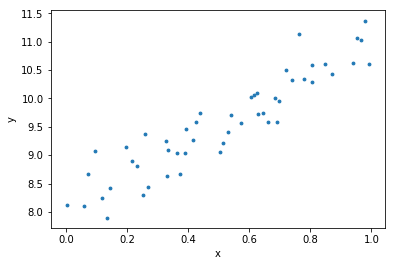

In [7]:
plt.scatter(x, y, s=8)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

* Want to recover `3` and `8` using SGD.
* Want to define a loss function.
* Output is continuous output, so problem requires regression. Common loss function is **mean squared error**.

In [8]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

* If, for example, we thought a=10 and b=5, then the MSE would be as follows:

In [9]:
y_hat = lin(10, 5, x)
mse(y_hat, y)

4.20402323579131

In [10]:
def mse_loss(a, b, x, y): return mse(lin(a, b, x), y)

In [11]:
mse_loss(10, 5, x, y)

4.20402323579131

* We have defined the *model* (linear regression) and the *evaluation criteria* (aka loss function), now we need to handle *optimisation*.

* Generate 1000 examples and turn them into variables:

In [12]:
x, y = gen_fake_data(10000, 3, 8)
x.shape, y.shape

((10000,), (10000,))

In [13]:
x, y = V(x), V(y)

* Create random weights, wrapped in Variable, settings the gradients to be calculated:

In [14]:
np.random.randn(1)

array([0.75506])

In [15]:
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)
a, b

(Variable containing:
  1.5550
 [torch.FloatTensor of size 1], Variable containing:
 -0.9018
 [torch.FloatTensor of size 1])

* Do gradient descent loop:

In [16]:
learning_rate = 1e-3

In [17]:
for t in range(10000):
    loss = mse_loss(a, b, x, y)
    if t % 1000 == 0: print(loss.data[0])
    
    # Compute the gradient with respect to Variables with `required_grad=True`
    # After this, you have a.grad and b.grad holding the respective gradients.
    loss.backward()
    
    # Update a and b with gradient descent
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Zero the gradients (note that it's changed in place)
    a.grad.data.zero_()
    a.grad.data.zero_()

93.01309204101562
28.7880916595459
0.23743104934692383
8.573080062866211
12.265936851501465
5.050601005554199
0.29957839846611023
0.8328072428703308
1.6128486394882202
0.8854061365127563


In [18]:
print(a)
print(b)

Variable containing:
 2.7402
[torch.FloatTensor of size 1]

Variable containing:
 7.8632
[torch.FloatTensor of size 1]



### 01:07:03 Gradient descent without PyTorch

In [42]:
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3

In [43]:
x, y = gen_fake_data(50, 3, 8)

In [44]:
a_guess, b_guess = -1, 1
mse_loss(y, a_guess, b_guess, x)

64.21509213659768

In [45]:
lr=0.01

In [46]:
def update():
    global a_guess, b_guess
    
    y_pred = lin(a_guess, b_guess, x)
    
    # Use calculus to calculate the derivatives
    dydb = 2 * (y_pred - y)
    dyda = x * dydb
    
    a_guess -= lr * dyda.mean()
    b_guess -= lr * dydb.mean()

* Can plot optimization using `FuncAnimation`:

In [105]:
!conda install -c conda-forge ffmpeg -yq



# All requested packages already installed.
# packages in environment at //anaconda/envs/fastai-cpu:
#
ffmpeg                    4.0                  hc8c182b_0    conda-forge


In [47]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x, y)
line, = plt.plot(x, lin(a_guess, b_guess, x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess, b_guess, x))
    for i in range(30): update()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 20), interval=100)
ani

## 01:09:15 - RNNs

* Download the collected works of Nietzsche:

In [52]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.fastai.learner import *
from fastai.fastai.column_data import *

from fastai.fastai.io import *

In [48]:
PATH='data/nietzsche'

In [53]:
get_data

<function fastai.fastai.io.get_data(url, filename)>

In [54]:
get_data('https://s3.amazonaws.com/text-datasets/nietzsche.txt', f'{PATH}nietzsche.txt')

nietzsche.txt: 606kB [00:03, 186kB/s]                             


In [55]:
text = open(f'{PATH}nietzsche.txt').read()

In [56]:
print('Corpus length:', len(text))

Corpus length: 600893


In [57]:
text[:400]

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to Truth, have been unskilled and unseemly methods for\nwinning a woman? Certainly she has never allowed herself '

* Going to build a character model which learns to write like Nietzsche.

### 01:10:24 - Why we need RNNs

1. Variable length sequence.
  * Very hard with conv nets, very straight forward in RNNs.
2. Long-term dependency
  * Want to keep track of some state over long-term dependancies.
    * Modelling code example: model needs to know if it's inside some sort of section, like a function or `<div>` block.
3. Stateful representation: understand context of what's come previously.
4. Memory

* Example: Swiftkey use RNN to predict next character you might type.

### 01:13:06 - Jeremy's neural net notation

* Example with simple neural network:

<img src="https://i.gyazo.com/f9a2130f2873a5a27d82f1415b29e44a.gif" width=400px>

  * First arrow = matrix product followed by relu - generates a set of activations.
  * Second arrow = softmax to generate output activations.

* Notation:
  * Rectangle = input.
  * Circle = hidden layer.
  * Triangle = output layer.
  * Every shape = activations.
  * Arrow = layer operation.

* CNN example:

<img src="https://i.gyazo.com/a6d579d8aa0f3be77c467962f6473ec4.gif" width=400px>

* Batch size removed from diagram.
* Activation type removed, because it's always quite similar.

1. Perform convolution with stride 2. Leaves you with activation of size `num_filters, height / 2, width / 2`.
2. Perform a flatten and matrix product, leaving you with number of activations.
3. Perform softmax to generate output.

* RNN example:

<img src="https://i.gyazo.com/795fc0ab906d02b3d8cede23daa90423.gif" width=400px>

* Want to try to predict the 3rd char using an input of the previous 2 chars.

1. Input first character of each string and generate some activations with a matrix product.
2. Put those activations through another matrix product, this time pass in and add the character 2s input to generate the next set of activations.
3. Perform softmax to predict characters.

### 01:20:38 - Implement char model

* Grab a set of all chars you see, sorted:

In [58]:
chars = sorted(list(set(text)))

In [62]:
chars[:12]

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1']

In [63]:
vocab_size = len(chars) + 1
print('total chars:', vocab_size)

total chars: 85


* Want to have zero value or null in dataset (for padding)

In [64]:
chars.insert(0, '\0')

In [65]:
''.join(chars[1:-6])

'\n !"\'(),-.0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxy'

* Want to map each character to a unique id (and back again):

In [66]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

* `idx` is the data used for model, which converts char to index

In [67]:
idx = [char_indices[c] for c in text]

In [68]:
idx[:5]

[40, 42, 29, 30, 25]

* Can confirm it's working by converting indexes back into characters:

In [70]:
''.join(indices_char[i] for i in idx[:70])

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not gro'

* Create inputs to model (predict the 4th character given the previous 3):

In [71]:
cs = 3
c1_dat = [idx[i] for i in range(0, len(idx) - 1 - cs, cs)]
c2_dat = [idx[i+1] for i in range(0, len(idx) - 1 - cs, cs)]
c3_dat = [idx[i+2] for i in range(0, len(idx) - 1 - cs, cs)]
c4_dat = [idx[i+3] for i in range(0, len(idx) - 1 - cs, cs)]

In [72]:
''.join(indices_char[i] for i in c1_dat[:10])

'PFE\nPSGh u'

* Create inputs:

In [74]:
x1 = np.stack(c1_dat[:-2])
x2 = np.stack(c2_dat[:-2])
x3 = np.stack(c3_dat[:-2])

In [77]:
print(x1)
print(c1_dat[:3])

[40 30 29 ... 67 68 72]
[40, 30, 29]


In [78]:
x1.shape

(200295,)

* Create output:

In [79]:
y = np.stack(c4_dat[:-2])

In [80]:
y[:4]

array([30, 29,  1, 40])

In [81]:
y.shape

(200295,)

* Need to decide how many activations and how many latent factors (aka how big is the embedding matrix):

In [82]:
n_hidden = 256
n_fac = 42

* Create the 3-char model as a `nn.Module`.
  * Note: we are creating 3 matrixes. One for characters, one for activations between FC and one for softmax output. Each arrow colour represents the same matrix:

<img src="https://i.gyazo.com/ab0a054793b8dc961cff8b1672881212.gif" width="400px">

In [83]:
class Char3Model(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        
        self.e = nn.Embedding(vocab_size, n_fac)
        
        # Green arrow from the diagram
        self.l_in = nn.Linear(n_fac, n_hidden)
        
        # Orange arrow from diagram (hidden to hidden operation)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        
        # Blue arrow from diagram (hidden to output operation)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        in1 = F.relu(self.l_in(self.e(c1)))
        in2 = F.relu(self.l_in(self.e(c2)))
        in3 = F.relu(self.l_in(self.e(c3)))
        
        # Start with empty activations to allow us to make RNN a for loop later
        h = V(torch.zeros(in1.size()))
        
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        
        return F.log_softmax(self.l_out(h))

#### 01:29:58 - Audience questions

* Q1: What are the dimensions for each layer?
* A1: 
  * `self.e` = length 42
  * `self.l_in` will return something of size hidden
  * `self.l_hidden` is square, so will return size `n_hidden` too
  * `self.l_out` returns `vocab_size`

* Can replace the 4 `h = ` lines in `forward`, with a for loop, which will makes it a recurrent neural net.

* Only using Fast.ai for the data loader:

In [84]:
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1, x2, x3], axis=1), y, bs=512)

In [86]:
md

In [85]:
m = Char3Model(vocab_size, n_fac)

In [87]:
it = iter(md.trn_dl)

# Grab a mini batch
*xs, yt = next(it)

In [91]:
xs[0].size()

torch.Size([512])

* Can call the model as a function by converting tensors to mini-batch:

In [92]:
t = m(*V(xs))

In [93]:
t

Variable containing:
-4.1909 -4.5987 -4.4961  ...  -4.4480 -4.5405 -4.3157
-4.3500 -4.3171 -4.7837  ...  -4.7370 -4.5965 -4.1207
-4.1188 -4.5435 -4.5411  ...  -4.5079 -4.5598 -4.1349
          ...             ⋱             ...          
-4.3233 -4.3477 -4.4115  ...  -4.6910 -4.5180 -4.3009
-4.4039 -4.2938 -4.6045  ...  -4.4588 -4.4035 -4.1867
-4.2590 -4.2989 -4.5310  ...  -4.4962 -4.8699 -4.2146
[torch.FloatTensor of size 512x85]

* Create an optimizer using standard PyTorch:

In [94]:
opt = optim.Adam(m.parameters(), 1e-2)

  * m.parameters() returns a list of parameters to optimize.

In [95]:
fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      2.079127   6.939734  



[6.939734]

* Since we don't have learning rate annealing, we can decreate the lr ourselves:

In [96]:
set_lrs(opt, 0.001)

In [97]:
fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.835597   6.586843  



[6.5868425]

In [98]:
fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.794173   6.583341  



[6.5833406]

* Write a function to test the model:

In [99]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [100]:
get_next('y. ')

'T'

In [101]:
get_next('ppl')

'e'

In [104]:
get_next(' th')

'e'

In [105]:
get_next('and')

' '

* Note that character model currently is a standard FC model, only thing slightly different is including the state of `h` in the FC layers.

### 01:37:43 - Implement char model as RNN

* Want to simplify char model diagram using a loop:

<img src="https://i.gyazo.com/a8ecdfd123c83a8d00daa2f9ec8a494e.gif" width=400px>

* Could be simplified future, by not making first char a special case:

<img src="https://i.gyazo.com/a6c645dc2219c77f86ceec30d00c7dd3.gif" width=400px>

### 01:39:37 - Audience questions

* Q1: Why reuse the same weight matrices - is it similar to filters in conv nets?
* A1: Sort of. A convolution is a different operation but they do both share a single set of weights.

* This time we'll use 8 chars to predict the 9th char:

In [107]:
cs = 8

* For each 0 through 7, create a list of each 8th char with that starting point:

In [111]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(len(idx) -cs -1)]

In [112]:
c_in_dat[:2]

[[40, 42, 29, 30, 25, 27, 29, 1], [42, 29, 30, 25, 27, 29, 1, 1]]

In [113]:
c_out_dat = [idx[j+cs] for j in range(len(idx) - cs - 1)]

In [114]:
xs = np.stack(c_in_dat, axis=0)

In [115]:
xs.shape

(600884, 8)

In [116]:
y = np.stack(c_out_dat)

* Each column is a series of 8 chars from the text:

In [117]:
xs[:cs,:cs]

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [42, 29, 30, 25, 27, 29,  1,  1],
       [29, 30, 25, 27, 29,  1,  1,  1],
       [30, 25, 27, 29,  1,  1,  1, 43],
       [25, 27, 29,  1,  1,  1, 43, 45],
       [27, 29,  1,  1,  1, 43, 45, 40],
       [29,  1,  1,  1, 43, 45, 40, 40],
       [ 1,  1,  1, 43, 45, 40, 40, 39]])

* Then y is the next char:

In [118]:
y[:cs]

array([ 1,  1, 43, 45, 40, 40, 39, 43])

#### 01:42:57 - Create and train model

In [119]:
val_idx = get_cv_idxs(len(idx) - cs - 1)

In [120]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

In [127]:
class CharLoopModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        
        h = V(torch.zeros(bs, n_hidden))
        for c in cs:
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp))
            
        return F.log_softmax(self.l_out(h))

In [128]:
m = CharLoopModel(vocab_size, n_fac)
opt = optim.Adam(m.parameters(), 1e-2)

* Why use a hyperbolic tanh (`F.tanh`)?
  * Very common to use in a state-to-state transition because it prevents values getting too high or too lower.
  * Similar to a sigmoid but appears to return values from -1 to 1.

In [129]:
fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      2.014126   1.988078  



[1.9880784]

In [130]:
set_lrs(opt, 0.001)

In [131]:
fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.718956   1.710837  



[1.7108371]

* Might want to rethink adding the h to inp because you might loose some information in the process. Instead, consider concatting them:

In [138]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        
        # Note: we're adding the hidden layer dimensions to layer
        self.l_in = nn.Linear(n_fac + n_hidden, n_hidden)
        
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden))
        for c in cs:
            # Use cat instead of `h+inp`
            inp = torch.cat((h, self.e(c)), 1)
            inp = F.relu(self.l_in(inp))
            h = F.tanh(self.l_hidden(inp))
            
        return F.log_softmax(self.l_out(h))

In [139]:
m = CharLoopConcatModel(vocab_size, n_fac)
opt = optim.Adam(m.parameters(), 1e-3)

In [140]:
fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.80335    1.776143  



[1.7761427]

In [141]:
set_lrs(opt, 1e-4)

In [142]:
fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.684319   1.694439  



[1.6944394]

* Can test model as above:

In [143]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [144]:
get_next('for thos')

'e'

In [145]:
get_next('part of ')

't'

In [146]:
get_next('who is i')

'n'

### 01:48:47 - Implement RNN with PyTorch

* PyTorch has tools to write the RNN loop and build the appropriate linear layers, using the `nn.RNN` class:

In [152]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        
        self.rnn = nn.RNN(n_fac, n_hidden)
        
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        
        # Runs the for loop above. Note that it still requires a starting point.
        # Note that in some cases, it can be useful to save hidden state.
        outp, h = self.rnn(inp, h)
        
        # outp is a list of outputs. Want to grab the last one.
        return F.log_softmax(self.l_out(outp[-1]))

* One minor difference between out implementation and PyTorches: `h` is a list of activations from each layer. That's why we have to get the last one: `outp[-1]`

In [148]:
m = CharRnn(vocab_size, n_fac)
opt = optim.Adam(m.parameters(), 1e-3)

In [153]:
fit(m, md, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.863854   1.84218   
    1      1.668912   1.666394                              
    2      1.593248   1.587343                              
    3      1.535342   1.552545                              



[1.5525452]

In [154]:
set_lrs(opt, 1e-4)

In [155]:
fit(m, md, 2, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.473912   1.50956   
    1      1.453243   1.503829                              



[1.5038285]

* Test model again:

In [160]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [161]:
get_next('for thos')

'e'

In [162]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:] + c
    return res

In [163]:
get_next_n('for thos', 40)

'for those and the same the same the same the sam'

* Useful to try to reimplement `nn.RNN` yourself and see if you get the same results out of PyTorch's implementation.

### 01:55:30 - Multi-output model

* One more change to model: returning an output after every iteration (note where the triangle is placed)

<img src="https://i.gyazo.com/cd7bc803f2b4a7aafed7817fac8e3b6e.gif" width=400px>

* Change to the for loop would be to accumulate the softmax outputs for each iteration:

  ```
  res = []
  for c in cs:
    # Use cat instead of `h+inp`
    inp = torch.cat((h, self.e(c)), 1)
    inp = F.relu(self.l_in(inp))
    h = F.tanh(self.l_hidden(inp))
    res.append(F.log_softmax(self.l_out(h))
  ```

* Then, instead of picking 8 chars and predicting the 9th, take 8 characters in a single `x` instance, and use the corresponding chars offset by one in `y`.
* First, take non-overlapping sets of chars:

In [164]:
c_in_dat = [[idx[i + j] for i in range(cs)] for j in range(0, len(idx) - cs - 1, cs)]

In [166]:
xs = np.stack(c_in_dat)
xs.shape

(75111, 8)

In [ ]:
* Create same thing, offset by 1:

In [170]:
c_out_dat = [[idx[i+j] for i in range(cs)] for j in range(1, len(idx) - cs, cs)]

In [171]:
ys = np.stack(c_out_dat)
ys.shape

(75111, 8)

In [172]:
xs[:cs, :cs]

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [ 1,  1, 43, 45, 40, 40, 39, 43],
       [33, 38, 31,  2, 73, 61, 54, 73],
       [ 2, 44, 71, 74, 73, 61,  2, 62],
       [72,  2, 54,  2, 76, 68, 66, 54],
       [67,  9,  9, 76, 61, 54, 73,  2],
       [73, 61, 58, 67, 24,  2, 33, 72],
       [ 2, 73, 61, 58, 71, 58,  2, 67]])

In [173]:
ys[:cs, :cs]

array([[42, 29, 30, 25, 27, 29,  1,  1],
       [ 1, 43, 45, 40, 40, 39, 43, 33],
       [38, 31,  2, 73, 61, 54, 73,  2],
       [44, 71, 74, 73, 61,  2, 62, 72],
       [ 2, 54,  2, 76, 68, 66, 54, 67],
       [ 9,  9, 76, 61, 54, 73,  2, 73],
       [61, 58, 67, 24,  2, 33, 72,  2],
       [73, 61, 58, 71, 58,  2, 67, 68]])

* Allows for training model "more efficiently".

In [175]:
val_idx = get_cv_idxs(len(xs) - cs - 1)

In [176]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [180]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp, h = self.rnn(inp, h)
        
        # Note: that the only change here is that we're taking all outputs
        # instead of just the last.
        return F.log_softmax(self.l_out(outp))

In [178]:
m = CharSeqRnn(vocab_size, n_fac)
opt = optim.Adam(m.parameters(), 1e-3)

In [185]:
it = iter(md.trn_dl)
*xst,yt = next(it)

In [186]:
yt.size()

torch.Size([512, 8])

* (02:00:41) One complexity: using negative log likelihood loss function, expects to receive 2 rank 1 tensors (with mini-batch: rank 2).
  * In this output, we have 8 timesteps each with 84 probabilities (a rank 3 tensor).
  * Can fix it as follows:

In [187]:
def nll_loss_seq(inp, targ):
    (sequence_length,
     batch_size, 
     num_hidden
    ) = inp.size()
    # Have to transpose so the axises match the input.
    # Then flatter.
    targ = targ.transpose(0, 1).contiguous().view(-1)
    # Flatten input and calculate negative log likelihood loss.
    return F.nll_loss(inp.view(-1, num_hidden), targ)

In [188]:
fit(m, md, 4, opt, nll_loss_seq)

epoch      trn_loss   val_loss                              
    0      1.118946   0.951573  
    1      0.843984   0.777325                               
    2      0.722619   0.691261                               
    3      0.651092   0.636679                               



[0.6366791]

* `fit` just implementes the training loop: should be all standard PyTorch stuff except the data.

#### 02:06:05 - Audience questions

* Q1. Should the sequence length be much longer in the multi-output model, given the first input only has 0s to go off?
* A1. Ideally, you'd line up the model, so that each batch passes some state to the next batch.
  * Could move the zero initialisation for `V(torch.zeros(1, bs, n_hidden))` into the constructor, then it's shared between forward prop calls.

### 02:08:20 - Using the identity matrix to initialise recurrent weight matrix

* If matrix multiple increases activations each time, it could cause exploding or vanishing gradients.
  * Want to ensure initial `l_hidden` should be of a size that doesn't cause activations to increase or decrease.
  * Geoffrey Hinton paper [A Simple Way To Initialize Recurrent Networks of Rectified Linear Units](https://arxiv.org/abs/1504.00941) proposes using identity matrix to initialize recurrent weight matrix.  
* Performed in one line below:

In [193]:
m = CharSeqRnn(vocab_size, n_fac)
opt = optim.Adam(m.parameters(), 1e-2)

In [194]:
m.rnn.weight_hh_l0.data.copy_(torch.eye(n_hidden))


    1     0     0  ...      0     0     0
    0     1     0  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      1     0     0
    0     0     0  ...      0     1     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 256x256]

In [195]:
fit(m, md, 4, opt, nll_loss_seq)

epoch      trn_loss   val_loss                               
    0      0.805777   0.713271  
    1      0.668829   0.642471                               
    2      0.622007   0.617288                               
    3      0.601317   0.615366                               



[0.6153661]

In [196]:
set_lrs(opt, 1e-3)

In [197]:
fit(m, md, 4, opt, nll_loss_seq)

epoch      trn_loss   val_loss                               
    0      0.527287   0.541712  
    1      0.502475   0.529744                               
    2      0.488283   0.52347                                
    3      0.478211   0.519096                               



[0.5190958]

* Clearly that helped a lot!